# Model Developement

> Different models will be developed here and tested here

In [ ]:
#| default_exp model_developement

In [ ]:
#| export
import os
#os.environ['CUDA_VISIBLE_DEVICES'] = ''
import tensorflow as tf
import datetime
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from pathlib import Path
from functools import partial
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from fastcore.basics import patch
from fastcore.all import *
from tensorflow.keras.models import Model
from IPython.display import display, clear_output
#from fastai.vision.all import *
from dataclasses import dataclass, field
from segmentation_test.preprocessing import *
from segmentation_test.config import *
#from segmentation_test.viz_utils import *
#from segmentation_test.viz_utils import *


from typing import Union, List, Tuple, Optional, Callable, Dict, Any

In [ ]:
mpl.rcParams['image.cmap'] = 'gray'

## Fully Convolutional Network

In [ ]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, Input

# Load the VGG16 model
vgg16 = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the layers in the VGG16 model
for layer in vgg16.layers:
    layer.trainable = False

# Define the input layer
input_layer = Input(shape=(224, 224, 3))

# Get the output of the VGG16 model
vgg_output = vgg16(input_layer)

# Add convolutional layers on top of the VGG16 model
conv1 = Conv2D(4096, (7, 7), activation='relu', padding='same')(vgg_output)
conv2 = Conv2D(4096, (1, 1), activation='relu', padding='same')(conv1)
conv3 = Conv2D(2, (1, 1), activation='softmax', padding='same')(conv2)

# Define the decoder
upsample1 = Conv2DTranspose(2, (4, 4), strides=(2, 2), padding='same')(conv3)
conv4 = Conv2D(512, (3, 3), activation='relu', padding='same')(upsample1)
conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv4)
upsample2 = Conv2DTranspose(2, (4, 4), strides=(2, 2), padding='same')(conv5)
conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(upsample2)
conv7 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)
upsample3 = Conv2DTranspose(2, (16, 16), strides=(8, 8), padding='same')(conv7)

# Create a new model with the VGG16 encoder and the decoder
fcn = Model(inputs=input_layer, outputs=upsample3)


In [ ]:
#| export
def blocks(
    x:tf.Tensor, 
    n_convs:int,
    filters:int,
    kernel_size:int=3,
    activation:str='relu',
    pool_size:int=2,
    pool_stride:int=2,
    name:str='block'):
    for i in range(n_convs):
        x = tf.keras.layers.Conv2D(
            filters=filters, 
            kernel_size=kernel_size, 
            padding='same',
            activation=activation, 
            name=f'{name}_conv{i}')(x)
    x = tf.keras.layers.MaxPool2D(
                                 pool_size=pool_size,
                                 strides=pool_stride,
                                 name=f'{name}_pool{i}'
                                 )(x)
    return x


In [ ]:
#| export
block_shortcut = partial(
                       blocks, kernel_size=(3,3),
                       pool_size=(2,2),
                       pool_stride=(2,2),
                       activation='relu')

In [ ]:
#| export
def VGG_16(
        input_image:tf.Tensor):

    x = block_shortcut(
            input_image, n_convs=2,
            filters=64,
            name='block1')
    p1 = x
    x = block_shortcut(
           x, n_convs=2,
           filters=128,
           name='block2')
    p2 = x
    x = block_shortcut(
            x, n_convs=3,
            filters=256,
            name='block3')
    p3 = x
    x = block_shortcut(
           x, n_convs=3,
           filters=512,
           name='block4')
    p4 = x
    x = block_shortcut(
           x, n_convs=3,
           filters=512,
           name='block5')
    p5 = x

    # creating model
    vgg = tf.keras.Model(
            inputs=input_image,
            outputs=p5)

    # This vgg is our encoder, now
    # we will process outer layer so that
    # decoder can work on it
    # number of filters for the output convolutional layers
    n = 4096

    # our input images are 224x224 pixels so they will be
    # downsampled to 7x7 after the pooling layers above.
    # we can extract more features by chaining two more
    # convolution layers.
    c6 = tf.keras.layers.Conv2D(
           n, (7, 7), padding='same',
           activation='relu',
           name='conv6')(p5)
    c7 = tf.keras.layers.Conv2D(
           n, (1, 1), padding='same',
           activation='relu',
           name='conv7')(c6)
    return (p1, p2, p3, p4, c7)

In [ ]:
data_path = Path.cwd().parent.parent.parent/'data_first/Trainingsdata_1024_1224'
IMAGE_HEIGHT = 1024
IMAGE_WIDTH = 1224
preprocess_obj = Preprocess(
                           image_path=data_path/'X',
                           label_path=data_path/'y',
                           im_height=IMAGE_HEIGHT,
                           im_width=IMAGE_WIDTH,
                           bs=BATCH_SIZE
                           )
train_ds, test_ds = preprocess_obj.create_train_test_dataset()

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


2023-04-13 14:17:58.202878: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:267] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2023-04-13 14:17:58.202950: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (ISCN5CG2091P37): /proc/driver/nvidia/version does not exist
2023-04-13 14:17:58.203354: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [ ]:
for img,lbl in train_ds.take(2):
    print(img.shape)
    print(np.max(lbl.numpy()))
    print(np.max(img.numpy()))


(10, 1024, 1224, 1)
1.0
1.0
(10, 1024, 1224, 1)
1.0
1.0


2023-04-13 14:18:00.397396: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


In [ ]:
#| export
def fcn_8_decoder(convs, n_classes):
    """
    Defines the FCN 8 decoder.
    Args:
    convs (tuple of tensors) - output of the encoder network
    n_classes (int) - number of classes
    Returns:
    tensor with shape (height, width, n_classes) containing class probabilities
    """
    # unpack the output of the encoder
    f1, f2, f3, f4, f5 = convs
    # upsample the output of the encoder then crop extra pixels # that were introduced
    o1 = tf.keras.layers.Conv2DTranspose(
               n_classes, kernel_size=(4, 4),
               strides=(2, 2),
               use_bias=False)(f5)
    o1 = tf.keras.layers.Cropping2D(
               cropping=(1, 1))(o1)
    # load the pool 4 prediction and do a
    # 1x1 convolution to reshape it to the same shape of `o1` above
    o2 = f4
    o2 = tf.keras.layers.Conv2D(
               n_classes,
               (1, 1),
               activation='relu',
               padding='same')(f4)
    # add the results of the upsampling and pool 4 prediction
    o1 = tf.keras.layers.Add()([o1, o2])

    # Now upsampling the resulting tensor 2 times
    o1 = tf.keras.layers.Conv2DTranspose(
              n_classes, (4, 4),
              strides=(2, 2),
              use_bias=False)(f3)
    o1 = tf.keras.layers.Cropping2D(
             cropping=(1, 1))(o1)

    # load the pool 3 prediction and do a 1x1 convolution to reshape it to the
    # same shape of `o1` above
    o2 = f2
    o2 = tf.keras.layers.Conv2D(
             n_classes, (1, 1),
             padding='same',
             activation='relu'
             )(f2)
    # add the results of the upsampling and pool 3 prediction
    o1 = tf.keras.layers.Add()([o1, o2])
    

    # upsample up to the size of the original image
    o1 = tf.keras.layers.Conv2DTranspose(
            num_classes,
            (8, 8),
            strides=(8, 8),
            use_bias=False)(f1)
    o1 = tf.keras.layers.Conv2D(
             n_classes, (1, 1),
             padding='same',
             activation='relu'
             )(o1)
    # append a softmax to get the class probabilities
    o1 = tf.keras.layers.Activation(
          'softmax')(o1)

    return o1

In [ ]:
#| export
def segmentation_model():
    """
    Model will be created from encoder and decoder
    """
    inputs = tf.keras.layers.Input(
           shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 1,))
    convs = VGG_16(
            input_image=inputs
            )
    outputs = fcn_8_decoder(
             convs,
             num_classes)
    model = tf.keras.Model(
            inputs=inputs,
            outputs=outputs)
    return model

In [ ]:
inputs = tf.keras.layers.Input(
        shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 1,))
convs = VGG_16(
        input_image=inputs
        )

In [ ]:
convs

(<KerasTensor: shape=(None, 512, 612, 64) dtype=float32 (created by layer 'block1_pool1')>,
 <KerasTensor: shape=(None, 256, 306, 128) dtype=float32 (created by layer 'block2_pool1')>,
 <KerasTensor: shape=(None, 128, 153, 256) dtype=float32 (created by layer 'block3_pool2')>,
 <KerasTensor: shape=(None, 64, 76, 512) dtype=float32 (created by layer 'block4_pool2')>,
 <KerasTensor: shape=(None, 32, 38, 4096) dtype=float32 (created by layer 'conv7')>)

In [ ]:
model = segmentation_model()

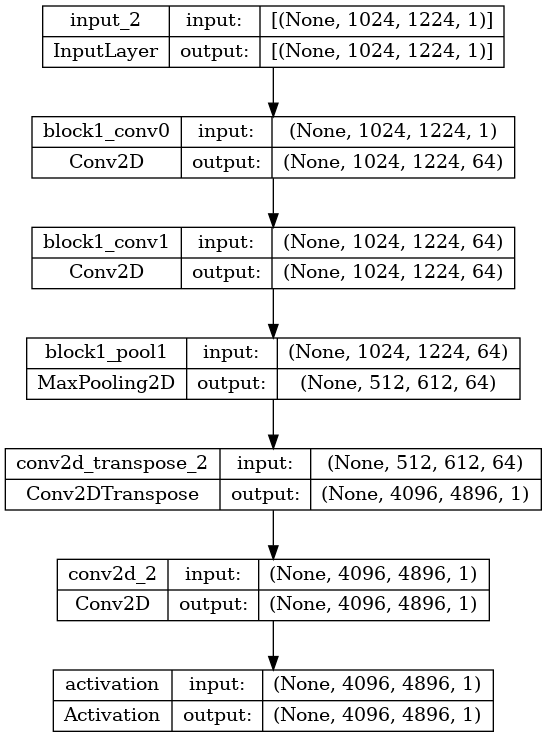

In [ ]:
show_model(model)

In [ ]:
#| export
class CosineDecay(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, initial_learning_rate, total_steps, warmup_steps=0, alpha=0.0, name=None):
        super().__init__()
        self.initial_learning_rate = tf.cast(initial_learning_rate, tf.float64)
        self.total_steps = total_steps
        self.warmup_steps = warmup_steps
        self.alpha = alpha
        self.name = name
        
    def __call__(self, step):
        if self.warmup_steps > 0:
            lr = (step / self.warmup_steps) * self.initial_learning_rate
        else:
            lr = self.initial_learning_rate
            
        cosine_decay = 0.5 * (1 + tf.math.cos(tf.constant(math.pi) * (tf.cast(step, dtype=tf.float32) - self.warmup_steps) / float(self.total_steps - self.warmup_steps)))
        decayed = (1 - self.alpha) * cosine_decay + self.alpha
        decayed = tf.cast(decayed, tf.float64)
        return lr * decayed
    
    def get_config(self):
        return {
            "initial_learning_rate": self.initial_learning_rate,
            "total_steps": self.total_steps,
            "warmup_steps": self.warmup_steps,
            "alpha": self.alpha,
            "name": self.name
        }
    


In [ ]:
preprocess_obj.bs

10

In [ ]:
epochs = 5
#from easy_pin_detection.config import *
#total_steps = train_count//BATCH_SIZE * epochs
#warmup_steps = int(0.25 * total_steps)
#total_steps, warmup_steps

(50, 12)

In [ ]:
#initial_learning_rate = 0.0001
#alpha = 0.1
#opt = tf.keras.optimizers.Adam(CosineDecay(
                                        #initial_learning_rate=initial_learning_rate,
                                        #total_steps=total_steps,
                                        #warmup_steps=warmup_steps,
                                        #alpha=alpha
                                        #)
                                #)

In [ ]:
#from easy_pin_detection.saki_tools import tversky_focal_loss

In [ ]:
#model.compile(
    #loss=tversky_focal_loss(alpha=0.7, beta=0.3,gamma=1.5, name='TFL'),
    #optimizer=opt,
    #metrics=[
            #'accuracy',
            #tf.keras.metrics.BinaryIoU(
                                            #name='iou_pin',
                                            #target_class_ids=[1],
                                            #threshold=0.5),

            #])

In [ ]:
#_date_str = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
#MODEL_SAVE_PATH     = data_path/'models'/_date_str
#MODEL_SAVE_FILE     = f"{_date_str}_saved_model"
#Path(MODEL_SAVE_PATH).mkdir(parents=True, exist_ok=True);
#MODEL_CPK_FILE      = "training_001/checkpoint.cpkt"
#TF_BOARD_LOG        = "training_001/.logs"
#MODEL_SAVE_PATH, MODEL_SAVE_FILE, MODEL_CPK_FILE, TF_BOARD_LOG

(Path('/home/goni/workspace/projects/easy_pin_detection/data_first/Trainingsdata_1024_1224/models/20230413-032741'),
 '20230413-032741_saved_model',
 'training_001/checkpoint.cpkt',
 'training_001/.logs')

In [ ]:
#tensorboard_callback = tf.keras.callbacks.TensorBoard(
        #log_dir=TF_BOARD_LOG, 
        #histogram_freq=0,
        #write_images=True, 
        #write_steps_per_second=True)
    
## Setup a training checkpoint
#model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
        #filepath=MODEL_CPK_FILE,
        #save_weights_only=True,
        #save_best_only=True,
        #monitor='loss',
        #verbose=1) 

#early_stopping = tf.keras.callbacks.EarlyStopping(
        ## Stop training when `val_loss` is no longer improving
        #monitor="val_loss",
        ## "no longer improving" being defined as "no better than 1e-2 less"
        #min_delta=1e-2,
        ## "no longer improving" being further defined as "for at least 2 epochs"
        #patience=5,
        #verbose=1,
    #)

In [ ]:
#def display(display_list):
  #plt.figure(figsize=(15, 15))

  #title = ['Input Image', 'True Mask', 'Predicted Mask']

  #for i in range(len(display_list)):
    #plt.subplot(1, len(display_list), i+1)
    #plt.title(title[i])
    #plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
    #plt.axis('off')
  #plt.show()

In [ ]:
#for images, masks in train_ds.take(2):
  #sample_image, sample_mask = images[0], masks[0]
  #display([sample_image, sample_mask])

In [ ]:
def create_mask(pred_mask):
  pred_mask = tf.math.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]

In [ ]:
def show_predictions(dataset=None, num=1):
  if dataset:
    for image, mask in dataset.take(num):
      pred_mask = model.predict(image)
      display([image[0], mask[0], create_mask(pred_mask)])
  else:
    display([sample_image, sample_mask,
             create_mask(model.predict(sample_image[tf.newaxis, ...]))])

In [ ]:
#class DisplayCallback(tf.keras.callbacks.Callback):
  #def on_epoch_end(self, epoch, logs=None):
    #clear_output(wait=True)
    #show_predictions()
    #print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

In [ ]:
#epochs = 1000
#initial_learning_rate = 0.001
#alpha = 0.1
#opt = tf.keras.optimizers.Adam(CosineDecay(
                                        #initial_learning_rate=initial_learning_rate,
                                        #total_steps=total_steps,
                                        #warmup_steps=warmup_steps,
                                        #alpha=alpha
                                        #)
                                #)
#model.compile(
    #loss=tversky_focal_loss(alpha=0.7, beta=0.3,gamma=1.5, name='TFL'),
    #optimizer=opt,
    #metrics=[
            #'accuracy',
            #tf.keras.metrics.BinaryIoU(
                                            #name='iou_pin',
                                            #target_class_ids=[1],
                                            #threshold=0.5),

            #])

#history = model.fit(train_ds,
                    #steps_per_epoch=steps_per_epoch, 
                    #validation_data=test_ds,
                    #validation_steps=validation_steps, 
                    #callbacks=[tensorboard_callback, model_checkpoint, DisplayCallback()],
                    #epochs=epochs)

#tf.saved_model.save(model, f'{MODEL_SAVE_PATH}/{MODEL_SAVE_FILE}')

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()